In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
from lightgbm import LGBMClassifier, early_stopping, log_evaluation
from sklearn.metrics import precision_recall_curve, auc, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import random
import lightgbm as lgb
SEED = 42
np.random.seed(SEED)
random.seed(SEED)



In [ ]:
df = pd.read_parquet("fraud_user_time_downsampled.parquet")
df.head()

,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Is Fraud?,timestamp,user_is_fraud,UseChipMissing
0,1236,1,1996,4,6,17:28,51.770000,0,-7375635960768263114,Palm Coast,FL,32137.0,5812,0,1996-04-06 17:28:00,1,0
1,1236,1,1996,4,7,16:29,50.869999,0,-6035332392926029059,Palm Coast,FL,32137.0,5812,0,1996-04-07 16:29:00,1,0
2,1236,1,1996,4,7,17:02,60.619999,0,-7375635960768263114,Palm Coast,FL,32137.0,5812,0,1996-04-07 17:02:00,1,0
3,1236,1,1996,4,8,05:45,156.860001,0,-5949357157231676152,ONLINE,Unknown,nan,4900,0,1996-04-08 05:45:00,1,1
4,1236,1,1996,4,8,15:14,18.650000,0,8576350507790891696,Palm Coast,FL,32137.0,5813,0,1996-04-08 15:14:00,1,0


In [ ]:
print(df['Is Fraud?'].mean())           # overall fraud rate
print(df['timestamp'].min(), df['timestamp'].max())
print(df.groupby('User')['Amount'].count().describe())

0.02844555761790818
1996-04-06 17:28:00 2019-11-26 02:02:00
count    1343.000000
mean      266.370812
std        98.150214
min        34.000000
25%       200.000000
50%       200.000000
75%       394.000000
max       400.000000
Name: Amount, dtype: float64


In [ ]:
# --- Create user-level fraud flag ---
if 'user_is_fraud' in df.columns:
    df = df.drop(columns=['user_is_fraud'])

user_fraud_map = (
    df.groupby('User')['Is Fraud?']
    .max()
    .reset_index()
    .rename(columns={'Is Fraud?': 'user_is_fraud'})
)

df = df.merge(user_fraud_map, on='User', how='left')

# --- Compute each user's first transaction date ---
if 'first_txn_time' in df.columns:
    df = df.drop(columns=['first_txn_time'])

user_first_txn = (
    df.groupby('User')['timestamp']
    .min()
    .reset_index()
    .rename(columns={'timestamp': 'first_txn_time'})
)

df = df.merge(user_first_txn, on='User', how='left')

# --- Sort users by first transaction time ---
user_first_txn = user_first_txn.sort_values('first_txn_time').reset_index(drop=True)

# --- Split users based on time quantiles (no overlap) ---
n_users = len(user_first_txn)
train_users = user_first_txn.iloc[:int(0.7 * n_users)]
val_users   = user_first_txn.iloc[int(0.7 * n_users):int(0.85 * n_users)]
test_users  = user_first_txn.iloc[int(0.85 * n_users):]

# --- Ensure fraud coverage ---
def ensure_fraud_coverage(source_users, target_users, df_source, frac=0.1):
    fraud_users_target = target_users['User'].isin(
        df_source.loc[df_source['user_is_fraud'] == 1, 'User']
    )
    if fraud_users_target.sum() == 0:
        fraud_from_source = (
            df_source[df_source['user_is_fraud'] == 1]
            .sample(frac=frac, random_state=42)[['User']]
        )
        target_users = pd.concat([target_users, fraud_from_source]).drop_duplicates()
    return target_users

val_users  = ensure_fraud_coverage(train_users, val_users, df)
test_users = ensure_fraud_coverage(train_users, test_users, df)

# --- Keep all transactions of selected users ---
train_df = df[df['User'].isin(train_users['User'])]
val_df   = df[df['User'].isin(val_users['User'])]
test_df  = df[df['User'].isin(test_users['User'])]

# --- Verify no overlap ---
assert len(set(train_df['User']).intersection(val_df['User'])) == 0
assert len(set(train_df['User']).intersection(test_df['User'])) == 0
assert len(set(val_df['User']).intersection(test_df['User'])) == 0

# --- Save ---
train_df.to_parquet("split_train.parquet", index=False)
val_df.to_parquet("split_val.parquet", index=False)
test_df.to_parquet("split_test.parquet", index=False)


# --- Summary ---
def show_summary(name, d):
    print(f"\n{name}")
    print("Rows:", len(d))
    print("Users:", d['User'].nunique())
    print("Fraud Txns:", d['Is Fraud?'].sum())
    print("Fraud %:", round(d['Is Fraud?'].mean() * 100, 4))
    print("Period:", d['timestamp'].min(), "→", d['timestamp'].max())

show_summary("Train", train_df)
show_summary("Val", val_df)
show_summary("Test", test_df)



Train
Rows: 266176
Users: 940
Fraud Txns: 7656
Fraud %: 2.8763
Period: 1996-04-06 17:28:00 → 2019-11-25 08:44:00

Val
Rows: 50476
Users: 201
Fraud Txns: 1589
Fraud %: 3.148
Period: 2012-04-28 08:55:00 → 2019-10-05 08:21:00

Test
Rows: 41084
Users: 202
Fraud Txns: 931
Fraud %: 2.2661
Period: 2015-11-29 04:08:00 → 2019-11-26 02:02:00


In [ ]:
def show_class_balance(name, df):
    counts = df['Is Fraud?'].value_counts().sort_index()
    total = len(df)
    fraud_ratio = (counts.get(1, 0) / total) * 100
    print(f"\n{name} Set:")
    print(counts)
    print(f"Total: {total}")
    print(f"Fraud Ratio: {fraud_ratio:.4f}%")
    print("-" * 40)

train_df = pd.read_parquet("split_train.parquet")
val_df   = pd.read_parquet("split_val.parquet")
test_df  = pd.read_parquet("split_test.parquet")


show_class_balance("Train", train_df)
show_class_balance("Validation", val_df)
show_class_balance("Test", test_df)



Train Set:
Is Fraud?
0    258520
1      7656
Name: count, dtype: int64
Total: 266176
Fraud Ratio: 2.8763%
----------------------------------------

Validation Set:
Is Fraud?
0    48887
1     1589
Name: count, dtype: int64
Total: 50476
Fraud Ratio: 3.1480%
----------------------------------------

Test Set:
Is Fraud?
0    40153
1      931
Name: count, dtype: int64
Total: 41084
Fraud Ratio: 2.2661%
----------------------------------------


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7656, number of negative: 258520
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016119 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 441
[LightGBM] [Info] Number of data points in the train set: 266176, number of used features: 8
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.028763 -> initscore=-3.519483
[LightGBM] [Info] Start training from score -3.519483
Training until validation scores don't improve for 50 rounds
[50]	valid_0's auc: 0.968175	valid_0's binary_logloss: 0.186245
Early stopping, best iteration is:
[3]	valid_0's auc: 0.946567	valid_0's binary_logloss: 0.113085

Best threshold for F1: 0.204

Confusion Matrix:
 [[39687   

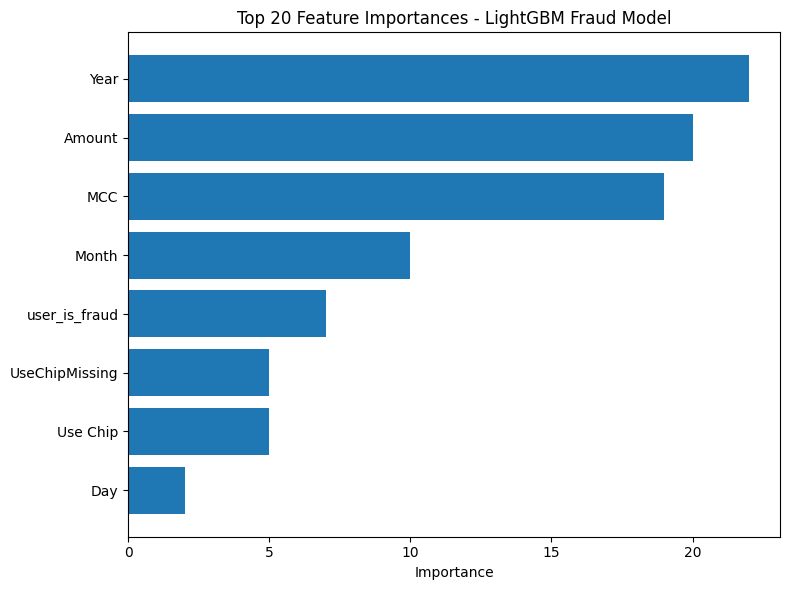


✅ Model saved to Drive at: /content/drive/MyDrive/mlba project/lightgbm_final_model.pkl


In [ ]:
# --- Load prepared splits from Drive (persistent path) ---
train_df = pd.read_parquet("split_train.parquet")
val_df   = pd.read_parquet("split_val.parquet")
test_df  = pd.read_parquet("split_test.parquet")

# --- Define target and features ---
target = 'Is Fraud?'
drop_cols = [
    'Is Fraud?', 'User', 'Card', 'timestamp',
    'Merchant Name', 'Merchant City', 'Merchant State', 'Zip'
]

# Drop or convert non-numeric columns that LightGBM cannot handle
non_numeric_cols = train_df.select_dtypes(include=['object', 'datetime']).columns.tolist()
drop_cols = list(set(drop_cols + non_numeric_cols))
features = [col for col in train_df.columns if col not in drop_cols]

# --- Prepare splits ---
X_train, y_train = train_df[features], train_df[target]
X_val, y_val     = val_df[features], val_df[target]
X_test, y_test   = test_df[features], test_df[target]

# --- Handle class imbalance ---
pos_weight = (len(y_train) - y_train.sum()) / y_train.sum()

# --- Initialize model ---
model = LGBMClassifier(
    n_estimators=1000,
    learning_rate=0.05,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=pos_weight,
    random_state=SEED
)

# --- Train model ---
model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric='auc',
    callbacks=[
        early_stopping(stopping_rounds=50),
        log_evaluation(period=50)
    ]
)

# --- Predict ---
y_pred_proba = model.predict_proba(X_test)[:, 1]

# --- Find best threshold for F1 ---
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
f1 = 2 * (precision * recall) / (precision + recall + 1e-9)
best_idx = f1.argmax()
best_threshold = thresholds[best_idx]

print(f"\nBest threshold for F1: {best_threshold:.3f}")

y_pred = (y_pred_proba >= best_threshold).astype(int)

# --- Evaluate ---
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=4, zero_division=0))

# --- Feature importance plot ---
importances = model.feature_importances_
indices = np.argsort(importances)[::-1][:20]

plt.figure(figsize=(8, 6))
plt.barh(range(len(indices)), importances[indices][::-1])
plt.yticks(range(len(indices)), [features[i] for i in indices][::-1])
plt.xlabel("Importance")
plt.title("Top 20 Feature Importances - LightGBM Fraud Model")
plt.tight_layout()
plt.show()

# --- Save trained model to Drive ---
import joblib
joblib.dump(model, "lightgbm_final_model.pkl")
print("\n✅ Model saved as lightgbm_final_model.pkl")


In [ ]:
# --- Behavioral / Temporal Feature Engineering (safe version) ---

# Sort by user and time
df = df.sort_values(['User', 'timestamp']).reset_index(drop=True)

# --- Rolling window aggregations ---
windows = [7, 30, 90]

for w in windows:
    df[f'amount_sum_{w}d'] = (
        df.groupby('User')['Amount']
          .transform(lambda x: x.rolling(window=w, min_periods=1).sum())
    )
    df[f'txn_count_{w}d'] = (
        df.groupby('User')['Amount']
          .transform(lambda x: x.rolling(window=w, min_periods=1).count())
    )
    df[f'avg_amt_{w}d'] = df[f'amount_sum_{w}d'] / (df[f'txn_count_{w}d'] + 1e-9)

# --- Spend ratios ---
df['spend_ratio_7_30'] = df['amount_sum_7d'] / (df['amount_sum_30d'] + 1e-9)
df['spend_ratio_30_90'] = df['amount_sum_30d'] / (df['amount_sum_90d'] + 1e-9)

# --- Merchant diversity (unique merchants in last 30 txns) ---
df['merchant_diversity_30'] = (
    df.groupby('User')['Merchant Name']
      .transform(lambda x: x.astype(str).rolling(window=30, min_periods=1)
      .apply(lambda w: len(set(w)), raw=False))
)

# --- Time gap features ---
df['prev_txn_time'] = df.groupby('User')['timestamp'].shift(1)
df['time_diff_hours'] = (df['timestamp'] - df['prev_txn_time']).dt.total_seconds() / 3600
df['avg_gap_7d'] = (
    df.groupby('User')['time_diff_hours']
      .transform(lambda x: x.rolling(window=7, min_periods=1).mean())
)

# --- Clean numeric-only columns safely ---
num_cols = df.select_dtypes(include=['float64', 'int64']).columns
df[num_cols] = df[num_cols].replace([np.inf, -np.inf], np.nan)
df[num_cols] = df[num_cols].fillna(0)

# --- Save enhanced dataset ---
df.to_parquet("df_with_behavioral_features.parquet", index=False)

print("✅ Behavioral and temporal features added successfully.")
print("New feature columns:", [c for c in df.columns if any(k in c for k in ['sum_', 'count_', 'avg_', 'ratio', 'diversity', 'gap'])])


✅ Behavioral and temporal features added successfully.
New feature columns: ['amount_sum_7d', 'txn_count_7d', 'avg_amt_7d', 'amount_sum_30d', 'txn_count_30d', 'avg_amt_30d', 'amount_sum_90d', 'txn_count_90d', 'avg_amt_90d', 'spend_ratio_7_30', 'spend_ratio_30_90', 'merchant_diversity_30', 'avg_gap_7d']


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7746, number of negative: 260282
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.097762 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3151
[LightGBM] [Info] Number of data points in the train set: 268028, number of used features: 22
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.028900 -> initscore=-3.514589
[LightGBM] [Info] Start training from score -3.514589
Training until validation scores don't improve for 50 rounds
[50]	valid_0's auc: 0.979588	valid_0's binary_logloss: 0.165666
Early stopping, best iteration is:
[2]	valid_0's auc: 0.950926	valid_0's binary_logloss: 0.111482

Best threshold for F1: 0.153

Confusion Matrix:
 [[39285 

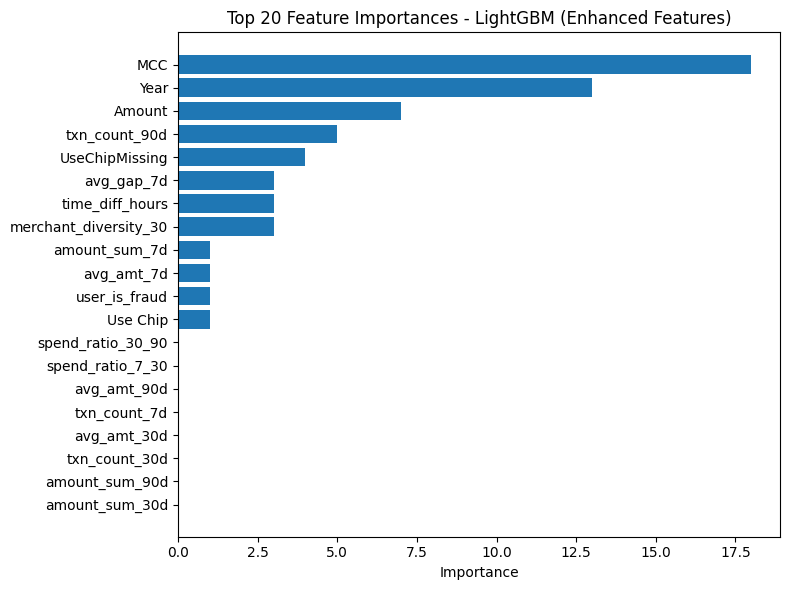

In [ ]:



# --- Split same as before (based on your saved user splits) ---
df = pd.read_parquet("df_with_behavioral_features.parquet")
train_df = pd.read_parquet("split_train.parquet")
val_df   = pd.read_parquet("split_val.parquet")
test_df  = pd.read_parquet("split_test.parquet")

# Merge new engineered features with existing splits using (User, timestamp)
merge_cols = ['User', 'timestamp']
train_df = train_df.merge(df[merge_cols + [c for c in df.columns if c not in train_df.columns]],
                          on=merge_cols, how='left')
val_df   = val_df.merge(df[merge_cols + [c for c in df.columns if c not in val_df.columns]],
                        on=merge_cols, how='left')
test_df  = test_df.merge(df[merge_cols + [c for c in df.columns if c not in test_df.columns]],
                         on=merge_cols, how='left')

# --- Target and feature selection ---
target = 'Is Fraud?'
drop_cols = [
    'Is Fraud?', 'User', 'Card', 'timestamp',
    'Merchant Name', 'Merchant City', 'Merchant State', 'Zip',
    'prev_txn_time', 'first_txn_time'
]

# Exclude any object/datetime columns
non_numeric = df.select_dtypes(include=['object', 'datetime']).columns.tolist()
drop_cols = list(set(drop_cols + non_numeric))

features = [col for col in train_df.columns if col not in drop_cols]

X_train, y_train = train_df[features], train_df[target]
X_val, y_val     = val_df[features], val_df[target]
X_test, y_test   = test_df[features], test_df[target]

# --- Model setup with imbalance handling ---
pos_weight = (len(y_train) - y_train.sum()) / y_train.sum()

model = LGBMClassifier(
    n_estimators=1000,
    learning_rate=0.05,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=pos_weight,
    random_state=42
)

# --- Train model with early stopping ---
model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric='auc',
    callbacks=[early_stopping(50), log_evaluation(50)]
)

# --- Evaluate on test set ---
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Find best threshold (max F1)
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
f1 = 2 * (precision * recall) / (precision + recall + 1e-9)
best_idx = f1.argmax()
best_threshold = thresholds[best_idx]

print(f"\nBest threshold for F1: {best_threshold:.3f}")

y_pred = (y_pred_proba >= best_threshold).astype(int)

print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=4, zero_division=0))

# --- PR-AUC ---
pr_auc = auc(recall, precision)
print(f"\nPrecision-Recall AUC: {pr_auc:.4f}")

# --- Feature Importance Plot ---
importances = model.feature_importances_
indices = np.argsort(importances)[::-1][:20]

plt.figure(figsize=(8, 6))
plt.barh(range(len(indices)), importances[indices][::-1])
plt.yticks(range(len(indices)), [features[i] for i in indices][::-1])
plt.xlabel("Importance")
plt.title("Top 20 Feature Importances - LightGBM (Enhanced Features)")
plt.tight_layout()
plt.show()


In [ ]:

# --- Compute precision-recall pairs across thresholds ---
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

# --- Convert to DataFrame for inspection ---
pr_df = pd.DataFrame({
    'threshold': thresholds,
    'precision': precision[:-1],
    'recall': recall[:-1],
    'f1': 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1] + 1e-9)
})

# --- Sort by F1 to see best overall threshold ---
best_f1_row = pr_df.iloc[pr_df['f1'].idxmax()]
print("\nBest F1 threshold summary:")
print(best_f1_row)

# --- Choose threshold meeting business goals ---
target_precision = 0.35
target_recall = 0.65

# Find thresholds that meet or exceed both targets
valid_thresholds = pr_df[
    (pr_df['precision'] >= target_precision) & (pr_df['recall'] >= target_recall)
]

if not valid_thresholds.empty:
    best_threshold = valid_thresholds.iloc[valid_thresholds['f1'].idxmax()]['threshold']
    print(f"\n✅ Threshold meeting target precision ≥{target_precision} and recall ≥{target_recall}: {best_threshold:.3f}")
else:
    best_threshold = best_f1_row['threshold']
    print(f"\n⚠️ No threshold meets both targets — using best F1 threshold: {best_threshold:.3f}")

# --- Predict using chosen threshold ---
y_pred = (y_pred_proba >= best_threshold).astype(int)

# --- Evaluate results ---
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=4, zero_division=0))



Best F1 threshold summary:
threshold    0.153194
precision    0.308642
recall       0.531350
f1           0.390472
Name: 201, dtype: float64

⚠️ No threshold meets both targets — using best F1 threshold: 0.153

Confusion Matrix:
 [[39285  1120]
 [  441   500]]

Classification Report:
               precision    recall  f1-score   support

           0     0.9889    0.9723    0.9805     40405
           1     0.3086    0.5313    0.3905       941

    accuracy                         0.9622     41346
   macro avg     0.6488    0.7518    0.6855     41346
weighted avg     0.9734    0.9622    0.9671     41346



In [ ]:
import optuna
import joblib


# --- Load data from Drive (persistent paths) ---
train_df = pd.read_parquet("split_train.parquet")
val_df   = pd.read_parquet("split_val.parquet")

target = 'Is Fraud?'

drop_cols = [
    'Is Fraud?', 'User', 'Card', 'timestamp',
    'Merchant Name', 'Merchant City', 'Merchant State', 'Zip',
    'prev_txn_time', 'first_txn_time'
]
non_numeric = train_df.select_dtypes(include=['object', 'datetime']).columns.tolist()
drop_cols = list(set(drop_cols + non_numeric))
features = [c for c in train_df.columns if c not in drop_cols]

X_train, y_train = train_df[features], train_df[target]
X_val, y_val     = val_df[features], val_df[target]

# --- Handle imbalance ---
pos_weight = (len(y_train) - y_train.sum()) / y_train.sum()

# --- Optuna objective ---
def objective(trial):
    params = {
        'n_estimators': 1000,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 15, 80),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 200),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 10.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 10.0),
        'scale_pos_weight': pos_weight,
        'random_state': SEED,
        'n_jobs': -1
    }

    model = LGBMClassifier(**params)
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric='auc',
        callbacks=[
            early_stopping(stopping_rounds=50),
            log_evaluation(period=50)
        ]
    )

    y_pred_proba = model.predict_proba(X_val)[:, 1]
    precision, recall, _ = precision_recall_curve(y_val, y_pred_proba)
    pr_auc = auc(recall, precision)

    return pr_auc

# --- Run Optuna study (reproducible) ---
study = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.TPESampler(seed=SEED)
)
study.optimize(objective, n_trials=30, show_progress_bar=True)

# --- Show results ---
print("\n✅ Best Parameters:")
for k, v in study.best_params.items():
    print(f"{k}: {v}")
print(f"\nBest PR-AUC on validation: {study.best_value:.4f}")

# --- Train final model using best params ---
best_params = study.best_params
best_params.update({
    'n_estimators': 1000,
    'scale_pos_weight': pos_weight,
    'random_state': SEED
})

final_model = LGBMClassifier(**best_params)
final_model.fit(X_train, y_train)

# --- Save model to Drive ---
joblib.dump(final_model, "lightgbm_tuned_model.pkl")
print("\n✅ Tuned LightGBM model saved at: lightgbm_tuned_model.pkl")


[I 2025-11-08 12:09:35,183] A new study created in memory with name: no-name-5ffacf2e-7cfb-4102-a12c-4f97916ffc66


  0%|          | 0/30 [00:00<?, ?it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7656, number of negative: 258520
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013939 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 441
[LightGBM] [Info] Number of data points in the train set: 266176, number of used features: 8
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.028763 -> initscore=-3.519483
[LightGBM] [Info] Start training from score -3.519483
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 9245, number of negative: 307407
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.084941 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 441
[LightGBM] [Info] Number of data points in the train set: 316652, number of used features: 8
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.029196 -> initscore=-3.504090
[LightGBM] [Info] Start training from score -3.504090
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[50]	valid_0's auc: 0.962582	valid_0's binary_logloss: 0.2132

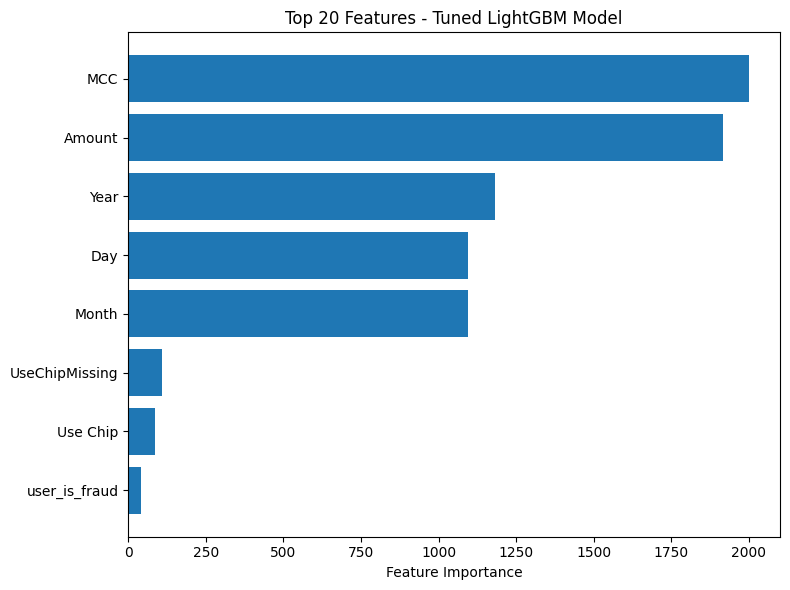


✅ Final tuned model retrained and saved to Drive as lightgbm_final_tuned_model.pkl


In [ ]:
# --- Load splits from Drive ---
train_df = pd.read_parquet("split_train.parquet")
val_df   = pd.read_parquet("split_val.parquet")
test_df  = pd.read_parquet("split_test.parquet")

# --- Combine train + val for final training ---
full_train = pd.concat([train_df, val_df], ignore_index=True)

target = 'Is Fraud?'
drop_cols = [
    'Is Fraud?', 'User', 'Card', 'timestamp',
    'Merchant Name', 'Merchant City', 'Merchant State', 'Zip',
    'prev_txn_time', 'first_txn_time'
]
non_numeric = full_train.select_dtypes(include=['object', 'datetime']).columns.tolist()
drop_cols = list(set(drop_cols + non_numeric))
features = [c for c in full_train.columns if c not in drop_cols]

X_train, y_train = full_train[features], full_train[target]
X_test, y_test   = test_df[features], test_df[target]

# --- Tuned parameters from Optuna ---
best_params = {
    'learning_rate': 0.15185703335329642,
    'num_leaves': 56,
    'max_depth': 10,
    'min_child_samples': 128,
    'subsample': 0.6516530631651889,
    'colsample_bytree': 0.6731067838824266,
    'reg_alpha': 8.70388319154227,
    'reg_lambda': 8.937835765925485,
    'n_estimators': 1000,
    'random_state': 42,
    'n_jobs': -1,
    'scale_pos_weight': (len(y_train) - y_train.sum()) / y_train.sum()
}

# --- Train final model ---
final_model = LGBMClassifier(**best_params)
final_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric='auc',
    callbacks=[early_stopping(stopping_rounds=50), log_evaluation(period=50)]
)

# --- Evaluate on test set ---
y_pred_proba = final_model.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall, precision)

# Best threshold by F1
f1 = 2 * (precision * recall) / (precision + recall + 1e-9)
best_idx = f1.argmax()
best_threshold = thresholds[best_idx]

y_pred = (y_pred_proba >= best_threshold).astype(int)

print(f"\nBest threshold for F1: {best_threshold:.3f}")
print(f"Precision-Recall AUC: {pr_auc:.4f}")

print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=4, zero_division=0))

# --- Plot feature importance ---
importances = final_model.feature_importances_
indices = np.argsort(importances)[::-1][:20]

plt.figure(figsize=(8, 6))
plt.barh(range(len(indices)), importances[indices][::-1])
plt.yticks(range(len(indices)), [features[i] for i in indices][::-1])
plt.xlabel("Feature Importance")
plt.title("Top 20 Features - Tuned LightGBM Model")
plt.tight_layout()
plt.show()

# --- Save final model to Drive ---
joblib.dump(final_model, "lightgbm_final_tuned_model.pkl")
print("\n✅ Final tuned model retrained and saved as lightgbm_final_tuned_model.pkl")
